##  该文本论述了几种图像处理方案，用于检测图像中矩形块，主要用到了边沿提取，图像形状分割与识别
方案1，这个是模拟一个图像，然后从图像中提取轮廓并绘图
假如是真的待检测的打印台与烟盒呢？，识别的应该是烟盒的轮廓，烟盒上各个区域块的轮廓
TODO ：需要继续写代码，将烟盒图输入并验证
### 方案一：定义一个再图像上画出,x,y 位置的标记点的函数

In [ ]:
def draw_circle(img, pos, circle_radius, color, line_width):
    cv2.circle(img, pos, circle_radius, color, line_width)
#     cv2.imshow('objDetect', bg) 
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def show_circle(img, pos, circle_radius, color, line_width):
    cv2.circle(img, pos, circle_radius, color, line_width)
    cv2.imshow('objDetect', img) 
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [22]:
import aircv as ac
import cv2
import os
os.getcwd()
# pos = ac.find_template(imsrc,imobj)
# image = cv2.pyrMeanShiftFiltering(image, 25, 10)
bg = 'bg_table.jpg'
bg = ac.imread(bg)
# bg =  cv2.cvtColor(bg,cv2.COLOR_BGR2GRAY)
# box =  cv2.cvtColor(box,cv2.COLOR_BGR2GRAY)
# obj =  cv2.cvtColor(obj,cv2.COLOR_BGR2GRAY)
boxlist = ['box0.png', 'box1.jpeg', 'box2.jpeg', 'box3.jpeg']
objlist = ['obj0.png', 'obj1.jpeg', 'obj2.jpeg', 'obj3.jpeg']
boxlist = [ac.imread(x) for x in boxlist]
objlist = [ac.imread(x) for x in objlist]
for i in range(len(boxlist)):
    pos_box = ac.find_template(boxlist[i],objlist[i])
    circle_center_pos  = pos_box['result']
    circle_center_pos = (int(circle_center_pos[0]),int(circle_center_pos[1]))
    circle_radius = 50
    color = (0, 255, 0)
    line_width = 5
    # draw circle
    show_circle(bg, circle_center_pos, circle_radius, color, line_width)
    

## 主要是矩形识别
方案二

1) 图像预处理 一般而言即使做普通的边缘检测也需要提前对图像进行降噪避免误测，比如最常见的办法是先对图像进行高斯滤波，然而这样也会导致图像变得模糊，当待检测图形边缘不明显，或是图像本身分辨率不高的情况下(比如本文用的例子)，会在降噪的同时把待检测的边缘强度也给牺牲了。具体到本文的例子，纸张是白色，背景是浅黄带纹路，如果进行高斯滤波是显然不行的，这时候一个替代方案是可以考虑使用Mean Shift，Mean Shift的优点就在于如果是像背景桌面的浅色纹理，图像分割的过程中相当于将这些小的浮动过滤掉，并且保留相对明显的纸张边缘
image = cv2.pyrMeanShiftFiltering(image, 25, 10)

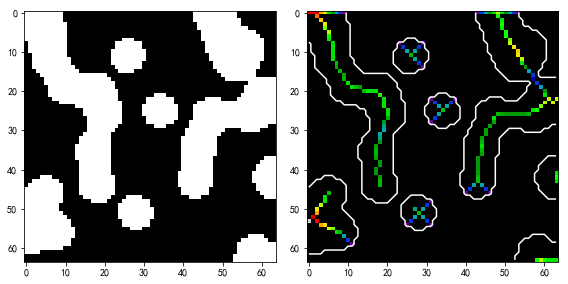

In [9]:
import numpy as np
import scipy.ndimage as ndi
from skimage import morphology
import matplotlib.pyplot as plt

#编写一个函数，生成测试图像
def microstructure(l=256):
    n = 5
    x, y = np.ogrid[0:l, 0:l]
    mask = np.zeros((l, l))
    generator = np.random.RandomState(1)  # 指定随机数种子
    points = l * generator.rand(3, n**2)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndi.gaussian_filter(mask, sigma=l/(4.*n))
    return mask > mask.mean()

李想吐 = microstructure(l=64) #生成测试图像

#计算中轴和距离变换值
skel, distance =morphology.medial_axis(李想吐, return_distance=True)

#中轴上的点到背景像素点的距离
dist_on_skel = distance * skel

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
#用光谱色显示中轴
ax2.imshow(dist_on_skel, cmap=plt.cm.spectral, interpolation='nearest')
ax2.contour(李想吐, [0.5], colors='w')  #显示轮廓线

fig.tight_layout()
plt.show()

In [33]:
def bianyanline(img):
    box =  cv2.cvtColor(img,cv2.COLOR)
    data = box
    # 计算中轴和距离变换值
    skel, distance =morphology.medial_axis(data, return_distance=True)
    # 中轴上的点到背景像素点的距离
    dist_on_skel = distance * skel
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
    #用光谱色显示中轴
    ax2.imshow(dist_on_skel, cmap=plt.cm.spectral, interpolation='nearest')
    ax2.contour(data, [0.5], colors='w')  #显示轮廓线
    fig.tight_layout()
    plt.show()

### 结论，该方法不太行，，对图像要求较高

2) 纸张边缘检测

虽然降噪了，可是图像里还是有很多边缘明显的元素。怎么尽量只保留纸张的边缘呢，这时候可以考虑用分割算法，把图像分为纸张部分和其他部分，这样分割的mask边缘就和纸张边缘应该是差不多重合的。在这里可以考虑用GrabCut，这样对于简单的情况，比如纸张或画布和背景对比强烈的，直接把图像边缘的像素作为bounding box就可以实现自动分割。当自动分割不精确的情况下再引入手动辅助分割，具体到我这里用的例子，背景和画面接近，所以需要手动辅助

In [24]:
import argparse
import imutils
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure,draw

box = '/Users/zhoudaoxian/Documents/RdataCode/bg.png' 
# box = '/Users/zhoudaoxian/Documents/RdataCode/allshape.jpg' 

# load the image, convert it to grayscale, blur it slightly,
# and threshold it
# img = cv2.imread("2.jpg", 0)  #Canny只能处理灰度图，所以将读取的图像转成灰度图  
# image = cv2.GaussianBlur(image,(3,3),0) #高斯平滑处理原图像降噪   
# image = cv2.Canny(image, 50, 150)     # apertureSize默认为3  

In [2]:
# load the image, convert it to grayscale, blur it slightly,
# and threshold it
image = cv2.imread(box)
cv2.imshow('121', image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0) # (image,(3,3),0) #高斯平滑处理原图像降噪   
ret,thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)

### 阈值化后的图像
1、轮廓的查找——cv::findContours()
函数cv::findContour是从二值图像中来计算轮廓的，它可以使用cv::Canny()函数处理的图像，因为这样的图像含有边缘像素；也可以使用cv::threshold()或者cv::adaptiveThreshold()处理后的图像，其边缘隐含在正负区域的交界处。


表示这种树的方式有很多种，OpenCV中使用数组（尤其是vectors）来表示这种树，其中数组中的每个条目都代表一个特定的轮廓，每个条目包含一个由4个整数组成的集合（通常表示为cv :: Vec4i类型的元素，就像四通道数组中的条目一样）。对于每个节点来说，四个元素所表示的含义分别如下：0号元素表示下一个轮廓（同一层级）；1号元素表示前一个轮廓（同一层级）；2号元素表示第一个子轮廓（下一层级）；3号元素表示父轮廓（上一层级）。

In [30]:
# cv2.imshow('imge of threshed', thresh)
# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)

In [31]:
cnts = cnts[0] if imutils.is_cv2() else cnts[1]

In [33]:
# cnts = cnts[0] if imutils.is_cv2() else cnts[1] 
# loop over the contours
for c in cnts:
	# compute the center of the contour
	M = cv2.moments(c)
	cX = int(M["m10"] / M["m00"])
	cY = int(M["m01"] / M["m00"])
 
	# draw the contour and center of the shape on the image
	cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
	cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
	cv2.putText(image, "center", (cX - 20, cY - 20),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
 
	# show the image
	cv2.imshow("Image", image)
	cv2.waitKey(0)

In [32]:
len(cnts)

1

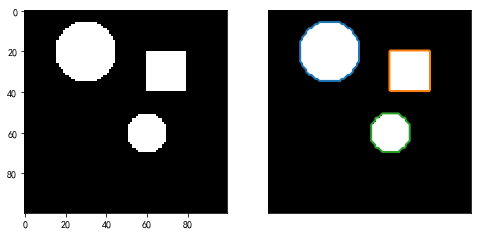

In [30]:
#生成二值测试图像
img=np.zeros([100,100])
img[20:40,60:80]=1  #矩形
rr,cc=draw.circle(60,60,10)  #小圆
rr1,cc1=draw.circle(20,30,15) #大圆
img[rr,cc]=1
img[rr1,cc1]=1
def draw_outline(img):
    #检测所有图形的轮廓
    contours = measure.find_contours(img, 0.5)

    #绘制轮廓
    fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,8))
    ax0.imshow(img,plt.cm.gray)
    ax1.imshow(img,plt.cm.gray)
    for n, contour in enumerate(contours):
        ax1.plot(contour[:, 1], contour[:, 0], linewidth=2)
    ax1.axis('image')
    ax1.set_xticks([])
    ax1.set_yticks([])
    plt.show()
组合图 = img
draw_outline(组合图)  #  特别理想的图，采用多次预处理后可尝试该方案，难以泛化

In [27]:
import matplotlib.pyplot as plt
from skimage import measure,data,color

def out_shadow(image):
    #生成二值测试图像
    img=color.rgb2gray(image)

    #检测所有图形的轮廓
    contours = measure.find_contours(img, 0.5)

    #绘制轮廓
    fig, axes = plt.subplots(1,2,figsize=(8,8))
    ax0, ax1= axes.ravel()
    ax0.imshow(img,plt.cm.gray)
    ax0.set_title('original image')

    rows,cols=img.shape
    ax1.axis([0,rows,cols,0])
    for n, contour in enumerate(contours):
        ax1.plot(contour[:, 1], contour[:, 0], linewidth=2)
    ax1.axis('image')
    ax1.set_title('contours')
    plt.show()

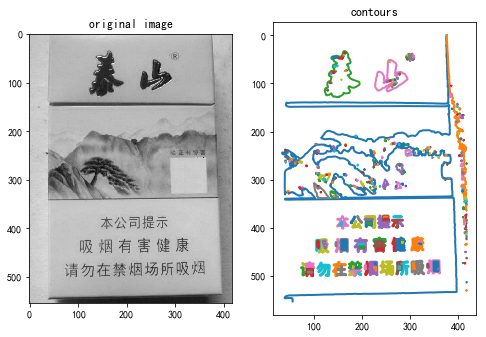

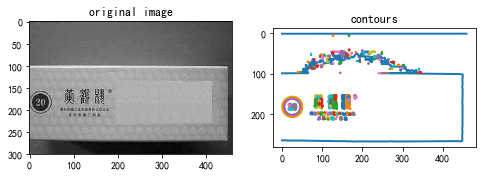

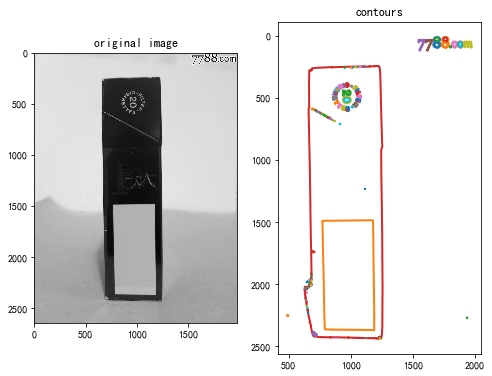

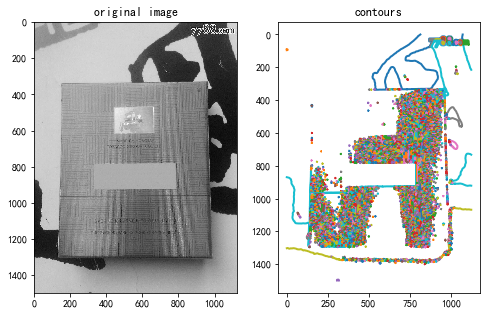

In [29]:
# out_shadow(data.horse())
for i in range(len(boxlist)):
    out_shadow(boxlist[i])

## 2、逼近多边形曲线

逼近多边形曲线有两个函数：subdivide_polygon（)和 approximate_polygon（）

subdivide_polygon（)采用B样条（B-Splines)来细分多边形的曲线，该曲线通常在凸包线的内部。

函数格式为：

skimage.measure.subdivide_polygon(coords, degree=2, preserve_ends=False)

coords: 坐标点序列。

degree: B样条的度数，默认为2

preserve_ends: 如果曲线为非闭合曲线，是否保存开始和结束点坐标，默认为false

返回细分为的坐标点序列。

approximate_polygon（）是基于Douglas-Peucker算法的一种近似曲线模拟。它根据指定的容忍值来近似一条多边形曲线链，该曲线也在凸包线的内部。

函数格式为:

skimage.measure.approximate_polygon(coords, tolerance)

coords: 坐标点序列

tolerance: 容忍值

返回近似的多边形曲线坐标序列。

In [36]:
# hand=color.rgb2gray(data.hand())
box = '/Users/zhoudaoxian/Documents/RdataCode/bg.png' 
image = cv2.imread(box)
# cv2.imshow('121', image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
def outline(hand):    
    for _ in range(5):
        new_hand =measure.subdivide_polygon(hand, degree=2)

    # approximate subdivided polygon with Douglas-Peucker algorithm
    appr_hand =measure.approximate_polygon(new_hand, tolerance=0.02)

    print("Number of coordinates:", len(hand), len(new_hand), len(appr_hand))

    fig, axes= plt.subplots(2,2, figsize=(9, 8))
    ax0,ax1,ax2,ax3=axes.ravel()

    ax0.plot(hand[:, 0], hand[:, 1],'r')
    ax0.set_title('original hand')
    ax1.plot(new_hand[:, 0], new_hand[:, 1],'g')
    ax1.set_title('subdivide_polygon')
    ax2.plot(appr_hand[:, 0], appr_hand[:, 1],'b')
    ax2.set_title('approximate_polygon')

    ax3.plot(hand[:, 0], hand[:, 1],'r')
    ax3.plot(new_hand[:, 0], new_hand[:, 1],'g')
    ax3.plot(appr_hand[:, 0], appr_hand[:, 1],'b')
    ax3.set_title('all')
    plt.show()
# outline(gray)
# cv2.cvtColor(bg,cv2.COLOR_BGR2GRAY)

In [30]:
from skimage import data,filters,feature
import matplotlib.pyplot as plt
img = data.camera()
def outcanny(img):    
    edges1 = feature.canny(img) #sigma=1
    edges2 = feature.canny(img,sigma=3) #sigma=3
    plt.figure('canny',figsize=(8,8))
    plt.subplot(121)

    plt.imshow(edges1,plt.cm.gray) 
    plt.subplot(122)
    plt.imshow(edges2,plt.cm.gray)
    plt.show()
    #   从结果可以看出，sigma越小，边缘线条越细小。

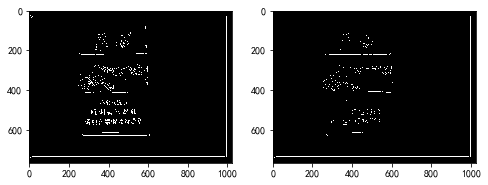

In [53]:
# from PIL import Image
# Image.open(box)
# I =  bg.convert('L')
# I = I.convert('1')
img = cv2.threshold(bg, 99, 123, cv2.THRESH_BINARY)
img[1]
outcanny(cv2.cvtColor(img[1], cv2.COLOR_BGR2GRAY))

### 3水平边缘检测：sobel_h, prewitt_h, scharr_h
垂直边缘检测： sobel_v, prewitt_v, scharr_v

可使用Roberts的十字交叉核来进行过滤，以达到检测交叉边缘的目的

In [35]:
from skimage import data,filters
import matplotlib.pyplot as plt
img = data.camera()
def filt_edge(img):
    edges1 = filters.sobel_h(img) 
    edges2 = filters.sobel_v(img) 
    plt.figure('sobel_v_h and filters of corss keneral',figsize=(8,8))
    plt.subplot(221)
    plt.imshow(edges1,plt.cm.gray) 
    plt.subplot(222)
    plt.imshow(edges2,plt.cm.gray)

    dst =filters.roberts_neg_diag(img) 
    plt.subplot(223)
    plt.title('十字交叉核 过滤后的边沿image')
    plt.imshow(dst,plt.cm.gray)
    dst2 =filters.roberts_pos_diag(img) 
    plt.subplot(224)
    plt.title('corss 2 image')
    plt.imshow(dst,plt.cm.gray)
    plt.show()

In [40]:
img.shape
# cv2.cvtColor(box,cv2.COLOR_BGR2GRAY)
for i in range(len(boxlist)):
    tmp = cv2.cvtColor(boxlist[i].shape, cv2.COLOR_BGR2GRAY)
    filt_edge(tmp)

error: OpenCV(3.4.1) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.cpp:11109: error: (-215) depth == 0 || depth == 2 || depth == 5 in function cvtColor


### 基于Otsu的阈值分割方法，函数调用格式：
此处定义了多种方法

/Users/zhoudaoxian/anaconda3/lib/python3.6/site-packages/skimage/filters/thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
/Users/zhoudaoxian/anaconda3/lib/python3.6/site-packages/skimage/filters/thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '


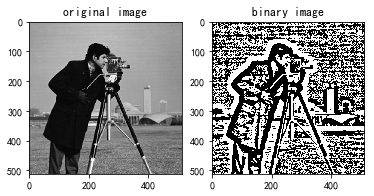

In [64]:
#
def otsu_binary(image):    
    thresh = filters.threshold_otsu(image) #返回一个阈值
    thresh = filters.threshold_yen(image)
    
    thresh = filters.threshold_li(image)
    thresh = filters.threshold_isodata(image)

    dst =(image <= thresh)*1.0 #根据阈值进行分割
    dst =filters.threshold_adaptive(image, 31,'mean') #返回一个阈值图像

    plt.subplot(121)
    plt.title('original image')
    plt.imshow(image,plt.cm.gray)
    plt.subplot(122)
    plt.title('binary image')
    plt.imshow(dst,plt.cm.gray)
    plt.show()
otsu_binary(img)

/Users/zhoudaoxian/anaconda3/lib/python3.6/site-packages/skimage/filters/thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
/Users/zhoudaoxian/anaconda3/lib/python3.6/site-packages/skimage/filters/thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '


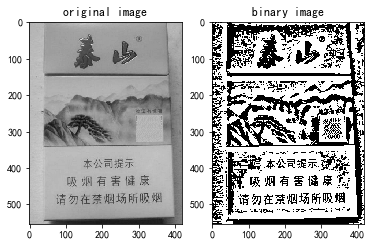

In [65]:
otsu_binary(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY))

## 1、膨胀（dilation)

原理：一般对二值图像进行操作。找到像素值为1的点，将它的邻近像素点都设置成这个值。1值表示白，0值表示黑，因此膨胀操作可以扩大白色值范围，压缩黑色值范围。一般用来扩充边缘或填充小的孔洞。

2、腐蚀（erosion)

函数：

skimage.morphology.erosion(image, selem=None）
selem表示结构元素，用于设定局部区域的形状和大小。
和膨胀相反的操作，将0值扩充到邻近像素。扩大黑色部分，减小白色部分。可用来提取骨干信息，去掉毛刺，去掉孤立的像素。



/Users/zhoudaoxian/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


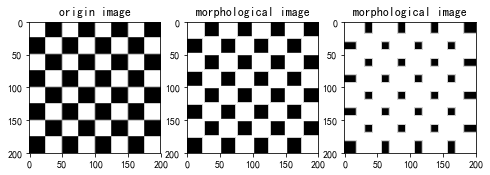

In [68]:
from skimage import data
import skimage.morphology as sm
import matplotlib.pyplot as plt
img=data.checkerboard()
dst1=sm.dilation(img,sm.square(5)) #用边长为5的正方形滤波器进行膨胀滤波
dst2=sm.dilation(img,sm.square(15)) #用边长为15的正方形滤波器进行膨胀滤波
plt.figure('morphology',figsize=(8,8))
plt.subplot(131)
plt.title('origin image')
plt.imshow(img,plt.cm.gray)
plt.subplot(132)
plt.title('morphological image')
plt.imshow(dst1,plt.cm.gray)
plt.subplot(133)
plt.title('morphological image')
plt.imshow(dst2,plt.cm.gray)
plt.show()

/Users/zhoudaoxian/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


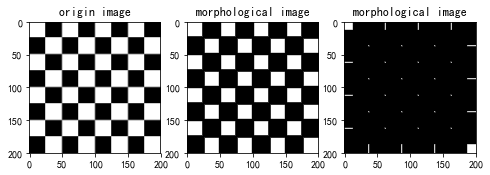

In [71]:
from skimage import data
import skimage.morphology as sm
import matplotlib.pyplot as plt
img=data.checkerboard()
dst1=sm.erosion(img,sm.square(5)) #用边长为5的正方形滤波器进行膨胀滤波
dst2=sm.erosion(img,sm.square(25)) #用边长为25的正方形滤波器进行膨胀滤波
plt.figure('morphology',figsize=(8,8))
plt.subplot(131)
plt.title('origin image')
plt.imshow(img,plt.cm.gray)
plt.subplot(132)
plt.title('morphological image')
plt.imshow(dst1,plt.cm.gray)
plt.subplot(133)
plt.title('morphological image')
plt.imshow(dst2,plt.cm.gray)
plt.show()


用此函数比处理灰度图像要快。
3、开运算（opening)
函数：

skimage.morphology.openning(image, selem=None）
selem表示结构元素，用于设定局部区域的形状和大小。
先腐蚀再膨胀，可以消除小物体或小斑块。

/Users/zhoudaoxian/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


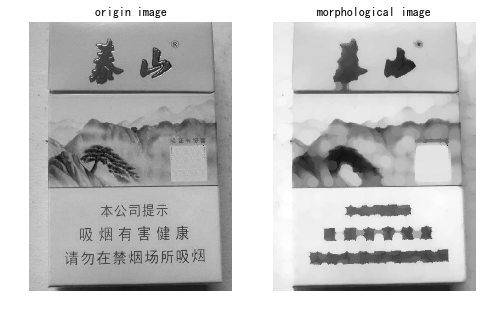

In [79]:
from skimage import io,color
import skimage.morphology as sm
import matplotlib.pyplot as plt
img=color.rgb2gray(io.imread('/Users/zhoudaoxian/Documents/RdataCode/bg.png' ))
dst=sm.opening(img,sm.disk(9)) #用边长为9的圆形滤波器进行膨胀滤波
plt.figure('morphology',figsize=(8,8))
plt.subplot(121)
plt.title('origin image')
plt.imshow(img,plt.cm.gray)
plt.axis('off')
plt.subplot(122)
plt.title('morphological image')
plt.imshow(dst,plt.cm.gray)
plt.axis('off')
plt.show()

## selem表示结构元素，用于设定局部区域的形状和大小。
先膨胀再腐蚀，可用来填充孔洞。

/Users/zhoudaoxian/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


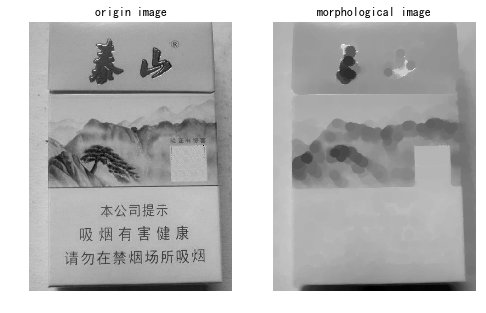

In [82]:
dst=sm.closing(img,sm.disk(9)) #用边长为5的圆形滤波器进行膨胀滤波
plt.figure('morphology',figsize=(8,8))
plt.subplot(121)
plt.title('origin image')
plt.imshow(img,plt.cm.gray)
plt.axis('off')
plt.subplot(122)
plt.title('morphological image')
plt.imshow(dst,plt.cm.gray)
plt.axis('off')
plt.show()


## 5、白帽（white-tophat)
函数：

skimage.morphology.white_tophat(image, selem=None）
selem表示结构元素，用于设定局部区域的形状和大小。
将原图像减去它的开运算值，返回比结构化元素小的白点

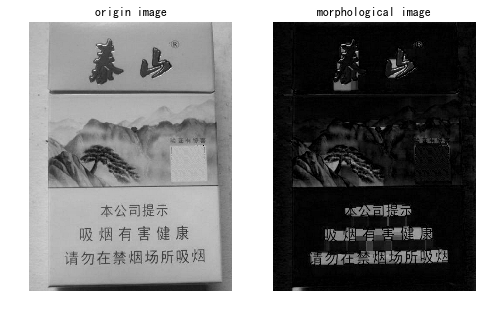

In [84]:
dst=sm.white_tophat(img,sm.square(21)) 
plt.figure('morphology',figsize=(8,8))
plt.subplot(121)
plt.title('origin image')
plt.imshow(img,plt.cm.gray)
plt.axis('off')
plt.subplot(122)
plt.title('morphological image')
plt.imshow(dst,plt.cm.gray)
plt.axis('off')
plt.show()

## 6、黑帽（black-tophat)
函数：

skimage.morphology.black_tophat(image, selem=None）
selem表示结构元素，用于设定局部区域的形状和大小。
将原图像减去它的闭运算值，返回比结构化元素小的黑点，且将这些黑点反色。

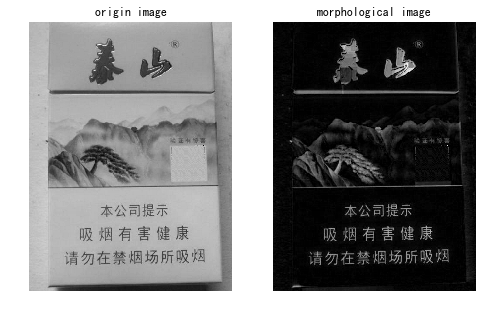

In [85]:
dst=sm.black_tophat(img,sm.square(21)) 
plt.figure('morphology',figsize=(8,8))
plt.subplot(121)
plt.title('origin image')
plt.imshow(img,plt.cm.gray)
plt.axis('off')
plt.subplot(122)
plt.title('morphological image')
plt.imshow(dst,plt.cm.gray)
plt.axis('off')
plt.show()